In [1]:
import face_recognition
import cv2
import os
import glob
import numpy as np
import random
import shutil
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tkinter as tk
from tkinter import filedialog
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

# EDA

In [2]:
# Specify the root directory path
root_path = './dataset/'

# Collect all the person names
dir_names = os.listdir(root_path)
person_names = [name.split("_")[-1].title() for name in dir_names]
n_individuals = len(person_names)

print(f"Total number of individuals: {n_individuals}\n")
print(f"Name of the individuals : \n\t{person_names}")

Total number of individuals: 105

Name of the individuals : 
	['Adrianalima', 'Alexandradaddario', 'Alexlawther', 'Alvaromorte', 'Alyciadabnemcarey', 'Amandacrew', 'Amberheard', 'Andysamberg', 'Annehathaway', 'Anthonymackie', 'Avrillavigne', 'Barackobama', 'Barbarapalvin', 'Benaffleck', 'Billgates', 'Bobbymorley', 'Brentonthwaites', 'Brianj.Smith', 'Brielarson', 'Camilamendes', 'Chrisevans', 'Chrishemsworth', 'Chrispratt', 'Christianbale', 'Cristianoronaldo', 'Daniellepanabaker', 'Dominicpurcell', 'Dwaynejohnson', 'Elizabethlail', 'Elizabetholsen', 'Elizataylor', 'Ellenpage', 'Elonmusk', 'Emiliaclarke', 'Emmastone', 'Emmawatson', 'Galgadot', 'Grantgustin', 'Gwynethpaltrow', 'Henrycavil', 'Hughjackman', 'Inbarlavi', 'Irinashayk', 'Jakemcdorman', 'Jasonmomoa', 'Jeffbezos', 'Jenniferlawrence', 'Jeremyrenner', 'Jessicabarden', 'Jimmyfallon', 'Johnnydepp', 'Joshradnor', 'Katharinemcphee', 'Katherinelangford', 'Keanureeves', 'Kiernenshipka', 'Krystenritter', 'Leonardodicaprio', 'Lilireinhart

In [3]:
# Number of images available per person
n_images_per_person = [len(os.listdir(root_path + name)) for name in dir_names]
n_images = sum(n_images_per_person)

# Show
print(f"Total Number of Images : {n_images}.")

Total Number of Images : 17534.


In [4]:
# Plot the Distribution of number of images per person.
fig = px.bar(x=person_names, y=n_images_per_person, color=person_names)
fig.update_layout({'title':{'text':"Distribution of number of images per person"}})
fig.show()

# Preprocessing

We took the existing database and created a new one by randomly selecting 10 pictures for each celebrity. The folder is called dataset_new

In [5]:
# Set the paths for the input and output folders
input_folder = './dataset/'
output_folder = './dataset_new/'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterate through each folder in the input folder
for folder_name in os.listdir(input_folder):
    folder_path = os.path.join(input_folder, folder_name)

    # Check if the item in the input folder is a directory
    if os.path.isdir(folder_path):
        # Check if there is a space in the folder name
        if " " in folder_name:
            # Create a new folder name with "First Last" format
            first_name, last_name = folder_name.split(" ", 1)
            new_folder_name = f"{first_name} {last_name}"
        else:
            # If there is no space, use the entire folder name
            new_folder_name = folder_name

        # Create the output folder for the current person if it doesn't exist
        output_person_folder = os.path.join(output_folder, new_folder_name)
        if not os.path.exists(output_person_folder):
            os.makedirs(output_person_folder)

        # Get the list of files in the current folder
        files = os.listdir(folder_path)
        
        # Select 10 random pictures
        selected_files = random.sample(files, min(10, len(files)))

        # Copy the selected files to the new folder
        for file_name in selected_files:
            source_path = os.path.join(folder_path, file_name)
            destination_path = os.path.join(output_person_folder, file_name)
            shutil.copy2(source_path, destination_path)

Then we display the contents of the new smaller database and verified that we still have the same amount of people (105)

In [6]:
path = './dataset_new/'

# Number of images available per person
n_images_per_person = [len(os.listdir(path + name)) for name in dir_names]
n_images = sum(n_images_per_person)
print(f"Total Number of Images : {n_images}.")

# Collect all the person names
dir_names = os.listdir(path)
person_names = [name.split("_")[-1].title() for name in dir_names]
print(f"Total number of individuals: {n_individuals}\n")


Total Number of Images : 1050.
Total number of individuals: 105



In [8]:
# Plot the Distribution of number of images per person.
fig = px.bar(x=person_names, y=n_images_per_person, color=person_names)
fig.update_layout({'title':{'text':"10 images per person"}})
fig.show()

training_set contains the first 5 pictures from the dataset_new folder

In [9]:
# Path to the dataset_new folder
dataset_path = "./dataset_new/"

# Create a new folder for the selected images
output_folder = "./training_set"
os.makedirs(output_folder, exist_ok=True)

# Loop through each folder in the dataset_new folder
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)

    # Check if the item in the dataset folder is a directory
    if os.path.isdir(folder_path):
        # List all files in the folder
        files = os.listdir(folder_path)

        # Sort files to make sure they are in order
        files.sort()

        # Take the first two images and create their source paths
        source_paths = [os.path.join(folder_path, file) for file in files[:5]]

        # Create the destination paths for the selected images
        destination_paths = [os.path.join(output_folder, f"{folder_name}_{i + 1}.jpg") for i in range(5)]

        # Copy the selected images to the new folder
        for source_path, destination_path in zip(source_paths, destination_paths):
            shutil.copyfile(source_path, destination_path)

print("Selected images have been copied to the 'training_set' folder.")


Selected images have been copied to the 'training_set' folder.


In [12]:
# this is where the magic begins, we create our FaceRec class, which creates the encodings to later detect faces

class FaceRec:
    def __init__(self):
        self.known_face_encodings = []
        self.known_face_names = []

        # Resize frame for faster processing
        self.frame_resizing = 0.25


    def load_encoding_images(self, images_path):
        images_path = glob.glob(os.path.join(images_path, "*.*"))

        total_images = len(images_path)
        detected_faces = 0  # Counter for images with detected faces

        print("{} encoding images found.".format(total_images))

        for img_path in images_path:
            try:
                img = cv2.imread(img_path)
                rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                filename = os.path.splitext(os.path.basename(img_path))[0]

            # Get encoding only if a face is detected
                face_encodings = face_recognition.face_encodings(rgb_img)
                if face_encodings:
                    img_encoding = face_encodings[0]

                    self.known_face_encodings.append(img_encoding)
                    self.known_face_names.append(filename)

                    detected_faces += 1  # Increment the counter
                else:
                    print(f"No face detected in {img_path}")
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")

    # Calculate accuracy
        accuracy = detected_faces / total_images
        print(f"Accuracy: {accuracy * 100:.2f}%")


    def detect_known_faces(self, frame):
        small_frame = cv2.resize(frame, (0, 0), fx=self.frame_resizing, fy=self.frame_resizing)
        rgb_small_frame = cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB)
        face_locations = face_recognition.face_locations(rgb_small_frame)
        face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)

        face_names = []
        for face_encoding in face_encodings:
            matches = face_recognition.compare_faces(self.known_face_encodings, face_encoding)
            name = "Unknown"

            face_distances = face_recognition.face_distance(self.known_face_encodings, face_encoding)
            best_match_index = np.argmin(face_distances)
            if matches[best_match_index]:
                name = self.known_face_names[best_match_index]
            face_names.append(name)

        # Adjust coordinates with frame resizing
        face_locations = (np.array(face_locations) / self.frame_resizing).astype(int)
        return face_locations, face_names
    
    
    def calculate_metrics(self, true_labels, predicted_labels):
        accuracy = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels, average='weighted')
        confusion_mat = confusion_matrix(true_labels, predicted_labels)

        return accuracy, precision, confusion_mat   

In this case, the accuracy is based on the model's ability to detect a face in the picture to create the embedding

In [13]:
# Create FaceRec instance
model = FaceRec()

# Load known face encodings from a folder
model.load_encoding_images("./training_set/")

525 encoding images found.
No face detected in ./training_set\AmberHeard_4.jpg
No face detected in ./training_set\BillGates_2.jpg
No face detected in ./training_set\BrianJ.Smith_5.jpg
No face detected in ./training_set\CristianoRonaldo_2.jpg
No face detected in ./training_set\ElizabethLail_2.jpg
No face detected in ./training_set\ElonMusk_3.jpg
No face detected in ./training_set\MariaPedraza_2.jpg
No face detected in ./training_set\NeilPatrickHarris_2.jpg
No face detected in ./training_set\SelenaGomez_3.jpg
No face detected in ./training_set\SelenaGomez_4.jpg
No face detected in ./training_set\TomEllis_1.jpg
No face detected in ./training_set\TomHardy_5.jpg
Accuracy: 97.71%


# **Face Recognition with WebCam**
---
Make sure to have your webcam ready and some pictures of famous people available!


``Press the "Esc" key when done``


In [16]:
# Load Camera
cap = cv2.VideoCapture(1)

true_labels = []
predicted_labels = []

while True:
    ret, frame = cap.read()

    # Detect Faces
    face_locations, face_names = model.detect_known_faces(frame)
    for face_loc, name in zip(face_locations, face_names):
        true_labels.append(name)
        predicted_labels.append(name)
        y1, x2, y2, x1 = face_loc[0], face_loc[1], face_loc[2], face_loc[3]
        cv2.putText(frame, name, (x1, y1 - 10), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 200), 2)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 200), 4)
    for name in face_names:
        true_labels.append(name)
        predicted_labels.append(name)    
    cv2.imshow("Frame", frame)

    key = cv2.waitKey(1)
    if key == 27:  # Press 'Esc' key to exit
        # Save a snapshot of the frame
        snapshot_filename = "snapshot.png"
        cv2.imwrite(snapshot_filename, frame)
        print(f"Prediction saved as {snapshot_filename}")
        break

# Calculate and print accuracy
accuracy = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred) / len(true_labels) * 100
print(f"Accuracy: {accuracy:.2f}%")

cap.release()
cv2.destroyAllWindows()

Prediction saved as snapshot.png
Accuracy: 100.00%


Accuracy: 1.00
Precision: 1.00
Confusion Matrix:
[[ 2  0  0  0  0  0]
 [ 0  6  0  0  0  0]
 [ 0  0 20  0  0  0]
 [ 0  0  0 16  0  0]
 [ 0  0  0  0  2  0]
 [ 0  0  0  0  0  2]]


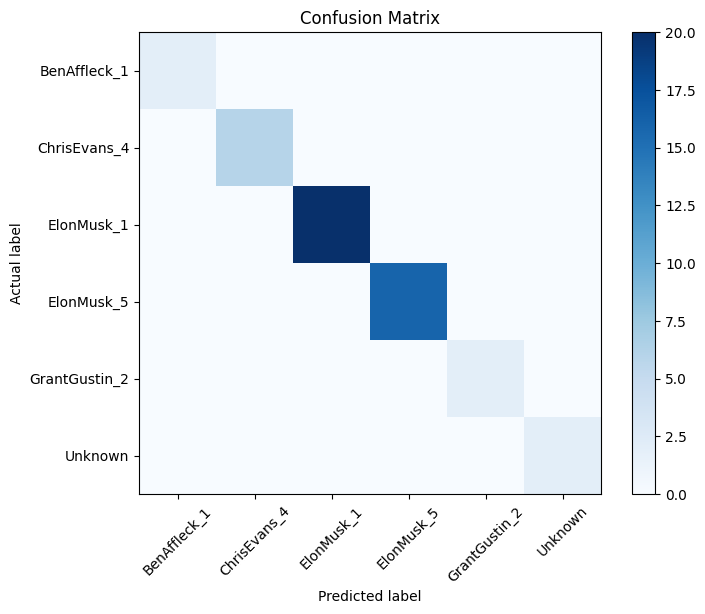

In [17]:
# After the loop, calculate and print the metrics
accuracy, precision, confusion_mat = model.calculate_metrics(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print("Confusion Matrix:")
print(confusion_mat)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = np.unique(true_labels + predicted_labels)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# **Image Comparision**
---
Use to compare 2 images with the preloaded encodings. A pop up window will appear which will let you select 2 images (browse your computer) then it will say "True" if it detects the same person in the pictures or "False" if is a different person.

In [ ]:
def compare_two_images():
    # Get file paths using a file dialog
    img_path1 = filedialog.askopenfilename(title="Select the first image")
    img_path2 = filedialog.askopenfilename(title="Select the second image")

    # Load and encode the first image
    img = cv2.imread(img_path1)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_encoding = face_recognition.face_encodings(rgb_img)[0]

    # Load and encode the second image
    img2 = cv2.imread(img_path2)
    rgb_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    img_encoding2 = face_recognition.face_encodings(rgb_img2)[0]

    # Assume you have ground truth labels (modify accordingly)
    true_labels = [True, True]  # Adjust based on your ground truth

    # Compare the face encodings
    result = face_recognition.compare_faces([img_encoding], img_encoding2)

    # Print "Same Person" or "Different Person" based on the result
    print("Result: ", "Same Person" if result[0] else "Different Person")

    # Display the images
    cv2.imshow("Img", img)
    cv2.imshow("Img 2", img2)

    # Wait for a key press
    key = cv2.waitKey(0) & 0xFF

# Create a Tkinter window
root = tk.Tk()
root.title("Face Recognition")

# Create a button to trigger image loading and comparison
button = tk.Button(root, text="Load and Compare Images", command=compare_two_images)
button.pack(pady=20)

# Run the Tkinter event loop
root.mainloop()

cv2.destroyAllWindows()  # Close the OpenCV windows
root.quit()  # Exit the Tkinter event loop